<a href="https://colab.research.google.com/github/eisbetterthanpi/vision/blob/main/selenium_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Pillow --upgrade


In [ ]:
# @title setup
# https://colab.research.google.com/github/kaliiiiiiiiii/Selenium-Profiles/blob/master/google-colab/selenium_profiles.ipynb

%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
#
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium

# Install xvfb
apt install -y xvfb

# Install Selenium-Profiles
pip uninstall -y selenium_profiles
pip install --no-cache-dir selenium_profiles>=2.2.6

# pip install https://github.com/kaliiiiiiiiii/Selenium-Profiles/archive/refs/heads/dev.zip # dev-branch

# install python packages
pip install google-colab-shell
pip install webdriver-manager
pip install Pyvirtualdisplay


In [ ]:
# @title service
# https://stackoverflow.com/questions/76428999/selenium-chrome-webdriver-stopped-working
# https://stackoverflow.com/questions/76409097/driver-webdriver-chrome-issues-with-a-selenium-approach-how-to-work-aro

!apt-get update
!apt-get install chromium chromium-driver
!pip3 install selenium

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

service = Service(executable_path="chromedriver")
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
driver = webdriver.Chrome(service=service, options=options)

url = "https://www.google.com/search?q=Semi-Detached+House+bungalow+modern+-plan+-interior+-illustration+-news+-model+-3D"
driver.get(url)  # test fingerprint
print(driver.title)


In [ ]:
# @title as funcs
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
import requests
import math
from PIL import Image
import matplotlib.pyplot as plt

# https://maps.google.com/maps

def gmap_latlng(location):
    location = location.replace(' ','+')
    location = location+'+singapore'
    uuu = 'https://www.google.com/maps/search/?api=1&query='+location
    driver.get(uuu)
    WebDriverWait(driver, 2).until(EC.presence_of_element_located((By.XPATH, "*//button[@aria-label='Search']")))
    driver.find_elements(By.XPATH,"*//button[@aria-label='Search']")[0].click()
    # print(driver.current_url)
    # for x in range(4):
    #     time.sleep(1)
    #     driver.find_elements(By.XPATH,"*//button[@aria-label='Search']")[0].click()
    #     print(driver.current_url)
    try: WebDriverWait(driver, 3).until(lambda driver: "/data=" in driver.current_url)
    except: return
    if not '!16s' in driver.current_url: return
    olat = driver.current_url.split('!3d')[1].split('!4d')[0]
    olng = driver.current_url.split('!4d')[1].split('!16s')[0]
    return float(olat), float(olng)


def heading_url(olat, olng):
    api_key = '_'
    location = str(olat)+', '+str(olng)
    uuu='https://maps.googleapis.com/maps/api/streetview/metadata?'+'location='+location+'&key='+api_key
    response = requests.get(uuu)
    # print(response.json())
    if response.json()['status'] != 'OK': return
    lat, lng = response.json()['location'].values()
    dist = ((olat-lat)**2 + (olng-lng)**2)**(1/2)*111111
    print('dist: ',dist)
    heading = 180-math.copysign(1, olng-lng)*(90)-math.atan((olat-lat)/(olng-lng))*(180/math.pi)
    url = 'https://www.google.com/maps/@?api=1&map_action=pano&viewpoint='+str(lat)+'%2C'+str(lng)+'&heading='+str(heading)+'&pitch=5&fov=80'
    return url


def gmap_direct_old(location):
    location = location.replace(' ','+')
    location = location+'+singapore'
    uuu = 'https://www.google.com/maps/search/?api=1&query='+location
    driver.get(uuu)
    WebDriverWait(driver, 2).until(EC.presence_of_element_located((By.XPATH, "*//button[@aria-label='Search']")))
    driver.find_elements(By.XPATH,"*//button[@aria-label='Search']")[0].click()
    # if not '!16s' in driver.current_url: return
    try: WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.XPATH, "*//button[@jsaction='pane.heroHeaderImage.click']")))
    except: return
    driver.find_elements(By.XPATH,"*//button[@jsaction='pane.heroHeaderImage.click']")[0].click()

    # try: WebDriverWait(driver, 7).until(lambda driver: "/data=" in driver.current_url)
    # except: return
    # uu = driver.current_url
    # fovl = uu.find(',75y,',33)
    # pitchl = uu.find(',90t/data',fovl)
    # fov, pitch = 80, 95
    # url = uu[:fovl+1] + str(fov) + uu[fovl+3:pitchl+1] + str(pitch) + uu[pitchl+3:]
    # driver.get(url)

    WebDriverWait(driver, 7).until(EC.presence_of_element_located((By.XPATH, "*//div[@role='contentinfo']/span[7]/span/span/span")))
    element = driver.find_elements(By.XPATH,"*//div[@role='contentinfo']/span[7]/span/span/span")[0]
    mon, yyyy = element.text.split(': ')[1].split(' ')
    months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    mm = months.index(mon)+1
    date= yyyy+'-'+str(mm).zfill(2)
    # time.sleep(1)

    # WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, "*//button[contains(@jsaction, 'drawer.close')]")))
    driver.find_elements(By.XPATH,"*//button[contains(@jsaction, 'drawer.close')]")[0].click()
    # print(driver.page_source)
    WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.XPATH, "*//button[contains(@jsaction, 'drawer.open')]")))
    delist=["*//div[@id='titlecard']",
    "*//div[@id='image-header']",
    "*//div[contains(@class, 'scene-footer-container')]",
    "*//div[contains(@class, 'app-viewcard-strip')]",
    "*//div[@id='watermark']",
    "*//button[contains(@jsaction, 'drawer.open')]",]
    # time.sleep(1)
    for delete in delist:
        delement = driver.find_element(By.XPATH, delete)
        driver.execute_script("arguments[0].remove();", delement)
    element = driver.find_elements(By.XPATH,"*//div[@aria-label='Google Maps']")[0]
    # element = driver.find_elements(By.XPATH,"*//div[@id='content-container']")[0]
    # element = driver.find_elements(By.XPATH,"*//div[@class='id-scene']")[0]
    # element = driver.find_elements(By.XPATH,"*//div[@aria-label='Street View']")[0]
    # element = driver.find_elements(By.XPATH,"*//canvas[contains(@class, 'widget-scene-canvas')]")[0]
    from selenium.webdriver import ActionChains
    # ActionChains(driver).drag_and_drop_by_offset(element, 100, 0).perform()
    # https://www.selenium.dev/documentation/webdriver/actions_api/mouse/
    # element = driver.find_elements(By.XPATH,"*//div[@id='consent-bump']")[0]
    ActionChains(driver).move_to_element(driver.find_elements(By.XPATH,"*//div[@id='consent-bump']")[0]).perform()

    # print(driver.get_window_size())
    # ActionChains(driver).move_by_offset(0, -300).perform()
    # action = ActionChains(driver)
    # action.click_and_hold(element)
    # action.move_by_offset(0, 20)
    # action.release().perform()
    screenshot = element.screenshot_as_png
    return screenshot, date



def gmap_direct(location):
    location = location.replace(' ','+')
    location = location+',+Singapore'
    uuu = 'https://www.google.com/maps/search/?api=1&query='+location
    # print(uuu)
    driver.get(uuu)
    try: WebDriverWait(driver, 2).until(EC.presence_of_element_located((By.XPATH, "*//button[@id='searchbox-searchbutton']")))
    except:
        driver.find_elements(By.XPATH,"*//form[@action='https://consent.google.com/save']//button")[0].click()
        WebDriverWait(driver, 2).until(EC.presence_of_element_located((By.XPATH, "*//button[@id='searchbox-searchbutton']")))
    driver.find_elements(By.XPATH,"*//button[@id='searchbox-searchbutton']")[0].click()
    # if not '!16s' in driver.current_url: return
    try: WebDriverWait(driver, 5).until(EC.presence_of_element_located((By.XPATH, "*//button[@jsaction='pane.heroHeaderImage.click']")))
    except: return
    driver.find_elements(By.XPATH,"*//button[@jsaction='pane.heroHeaderImage.click']")[0].click()
    # print("here")
    try: WebDriverWait(driver, 5).until(lambda driver: ",90t/data=" in driver.current_url)
    except: return
    uu = driver.current_url
    # print(uu)
    fovl = uu.find(',75y,',33)
    pitchl = uu.find(',90t/data',fovl)
    fov, pitch = 80, 95
    url = uu[:fovl+1] + str(fov) + uu[fovl+3:pitchl+1] + str(pitch) + uu[pitchl+3:]
    # print(url)
    driver.get(url)

    WebDriverWait(driver, 8).until(EC.presence_of_element_located((By.XPATH, "*//div[@role='contentinfo']/span[7]/span/span/span")))
    element = driver.find_elements(By.XPATH,"*//div[@role='contentinfo']/span[7]/span/span/span")[0]
    mon, yyyy = element.text.split(': ')[1].split(' ')
    months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    mm = months.index(mon)+1
    date= yyyy+'-'+str(mm).zfill(2)

    # list of screen elements to delete
    delist=["*//div[@id='titlecard']",
    "*//div[@id='image-header']",
    "*//div[contains(@class, 'scene-footer-container')]",
    "*//div[contains(@class, 'app-viewcard-strip')]",
    "*//div[@id='watermark']",]
    # "*//button[contains(@jsaction, 'drawer.open')]",]

    try:
        # driver.find_element_by_xpath("*//button[contains(@jsaction, 'drawer.close')]")
        # print(EC.presence_of_element_located((By.XPATH, "*//button[contains(@jsaction, 'drawer.open')]")))
        # if EC.presence_of_element_located((By.XPATH, "*//button[contains(@jsaction, 'drawer.open')]")):
        driver.find_elements(By.XPATH,"*//button[contains(@jsaction, 'drawer.close')]")[0].click()
        delist.append("*//button[contains(@jsaction, 'drawer.open')]")
        WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.XPATH, "*//button[contains(@jsaction, 'drawer.open')]")))
    except: pass

    try:
        driver.find_elements(By.XPATH,"*//div[@role='alert']")[0]
        delist.append("*//div[@role='alert']")
    except: pass

    for delete in delist:
        delement = driver.find_element(By.XPATH, delete)
        driver.execute_script("arguments[0].remove();", delement)
    element = driver.find_elements(By.XPATH,"*//div[@aria-label='Google Maps']")[0]
    from selenium.webdriver import ActionChains
    # print(driver.page_source)
    ActionChains(driver).move_to_element(driver.find_elements(By.XPATH,"*//div[@id='consent-bump']")[0]).perform()
    screenshot = element.screenshot_as_png
    return screenshot, date



def get_screenshot(url):
    driver.get(url)
    WebDriverWait(driver, 7).until(EC.presence_of_element_located((By.XPATH, "*//div[@role='contentinfo']/span[7]/span/span/span")))
    element = driver.find_elements(By.XPATH,"*//div[@role='contentinfo']/span[7]/span/span/span")[0]
    mon, yyyy = element.text.split(': ')[1].split(' ')
    months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    mm = months.index(mon)+1
    date= yyyy+'-'+str(mm).zfill(2)
    delist=["*//div[@id='titlecard']",
    "*//div[@id='image-header']",
    "*//div[contains(@class, 'scene-footer-container')]",
    "*//div[contains(@class, 'app-viewcard-strip')]",
    "*//div[@id='watermark']",]
    for delete in delist:
        delement = driver.find_element(By.XPATH, delete)
        driver.execute_script("arguments[0].remove();", delement)
    element = driver.find_elements(By.XPATH,"*//div[@aria-label='Street View']")[0]
    screenshot = element.screenshot_as_png
    return screenshot, date


# 40000km, 360deg
# 40000000/360 = 1000000/9 = 111111m/deg


location = "7 THIRD ST" #
# fov : ',75y,'
# pitch: ',90t/data'
# olat, olng = gmap_latlng(location)
# print(olat, olng)

# url = heading_url(olat, olng)
# print(url)

# screenshot, date = get_screenshot(url)
# print(date)


# screenshot, date = gmap_direct(location)
# print(date)
# driver.get_screenshot_as_file("LambdaTestVisibleScreen.png")

with open('canvas.png', 'wb') as f:
    f.write(screenshot)

from PIL import Image

# # plt.imshow(np.transpose(pic_content, (1, 2, 0)))
# # image = Image.open(screenshot).convert("RGB")
# image = Image.open('canvas.png').convert("RGB")
# plt.figure(figsize=(5, 3))
# plt.axis('off')
# plt.imshow(image)
# plt.show()


In [3]:
# @title scrape google
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
import requests
import math
from PIL import Image
import matplotlib.pyplot as plt


url="https://www.google.com/search?sxsrf=AB5stBjzK4Qjah_pvMXlxkPxv3P1VZb1nQ:1688463777227&q=Semi-Detached+House+bungalow+modern+-plan+-interior+-illustration+-news+-model+-3D&tbm=isch&sa=X&ved=2ahUKEwiWh6Hd4fT_AhUp1jgGHb3WCAkQ0pQJegQIChAB&biw=1286&bih=876&dpr=1"
# url = "https://www.google.com/search?q=Semi-Detached+House+bungalow+modern+-plan+-interior+-illustration+-news+-model+-3D&tbm=isch&ved=2ahUKEwjdlP7RvPL_AhUAyKACHRdGAW4Q2-cCegQIABAA&oq=Semi-Detached+House+bungalow+modern+-plan+-interior+-illustration+-news+-model+-3D"
# url = "https://www.google.com/search?q=terrace+modern+design+%22properties%22+-youtube+-plan+-interior+-illustration+-news+-model+-3D&tbm=isch&safe=active&chips=q:terrace+modern+design+properties+-youtube+-plan+-interior+-illustration+-news+-model+-3d,online_chips:3bdrm+townhouse"
# url = "https://www.google.com/search?sxsrf=AB5stBiZ6cUkUivPpaWz3iSX09llLBFmqg:1688459159623&q=terrace+home+modern+design&tbm=isch&sa=X&ved=&biw=1286&bih=876&dpr=1#imgrc=o-90EBgQu5d1eM"
# url = "https://www.google.com/search?sxsrf=AB5stBiZ6cUkUivPpaWz3iSX09llLBFmqg:1688459159623&q=terrace+home+modern+design&tbm=isch&sa=X&ved=2ahUKEwjR47TD0PT_AhWCxDgGHW9AD6oQ0pQJegQICBAB&biw=1286&bih=876&dpr=1"

driver.get(url)

reject = driver.find_elements(By.XPATH,"*//button[@aria-label='Reject all']")#[0]#.click()
if reject: reject[0].click()






# scroll to the end, load everything
def scroll_end(driver):
    end = driver.find_elements(By.XPATH,'''*//div[@data-endedmessage="Looks like you've reached the end"]''')[0]#.click()
    # print(end.get_attribute("data-status")) # =5, =3 when reach end
    # while end.get_attribute("data-status") == "5":
    while end.get_attribute("data-status") != "3":
        more = driver.find_elements(By.XPATH,"*//input[@value='Show more results']")[0]#.click()
        # driver.find_elements(By.XPATH,"*//input[@value='Show more results']")[0].click()
        if more.is_displayed(): more.click()
        # height = driver.execute_script("return document.body.scrollHeight")
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") # scroll down
    # 33sec 14s 21s
# scroll_end(driver)

# # # click in each image, way too slow
# img_urls=[]
# try: WebDriverWait(driver, 2).until(EC.presence_of_element_located((By.XPATH, "*//a[@class='wXeWr islib nfEiy']")))
# except: pass
# hits = driver.find_elements(By.XPATH,"*//a[@class='wXeWr islib nfEiy']") # images
# # driver.execute_script("hits = document.getElementsByClassName('wXeWr islib nfEiy')")

# import time
# start = time.time()
# print(len(hits))
# # for i, button in enumerate(hits):
# for i, button in enumerate(hits[90:]):
#     hits[i].click()
#     # driver.execute_script("hits["+str(i)+"].click();")
#     # try: img_src = driver.find_elements(By.XPATH,"*//img[@jsname='kn3ccd']")[0].get_attribute("src")
#     # except: continue
#     # img_src = driver.find_elements(By.XPATH,"*//a[@class='Du2c7e']")[0].get_attribute("href")
#     # img_src = driver.find_elements(By.XPATH,"*//a[@class='Du2c7e']/img")[0].get_attribute("src")

#     WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.XPATH, "*//a[@aria-label='See more Related content']")))
#     see_mor = driver.find_elements(By.XPATH,"*//a[@aria-label='See more Related content']")[0].get_attribute("href")
#     # print(i, img_src)
#     print(i, see_mor)
#     end = time.time()
#     print(end-start)
#     start=end
#     # img_urls.append(img_src)
#     # if i>3: break
# # print(len(img_urls))



In [12]:
# @title funcs

def scroll_end(driver):
    end = driver.find_elements(By.XPATH,'''*//div[@data-endedmessage="Looks like you've reached the end"]''')[0]#.click()
    while end.get_attribute("data-status") != "3": # =5, =3 when reach end
        more = driver.find_elements(By.XPATH,"*//input[@value='Show more results']")[0]#.click()
        if more.is_displayed(): more.click()
        # height = driver.execute_script("return document.body.scrollHeight")
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") # scroll down

start = time.time()
scroll_end(driver)
end = time.time()
print(end-start) # 23.4sec 11.77s
start=end

def click_all(driver):
    see_more=[]
    hits = driver.find_elements(By.XPATH,"*//a[@class='wXeWr islib nfEiy']")
    driver.execute_script("hits = document.getElementsByClassName('wXeWr islib nfEiy')")
    print(len(hits)) # 780
    # for i, x in enumerate(hits):
    for i in range(len(hits)):
        # hits[i].click()
        driver.execute_script("hits["+str(i)+"].click();")
        try:
            WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.XPATH, "*//a[@aria-label='See more Related content']")))
            see_mor = driver.find_elements(By.XPATH,"*//a[@aria-label='See more Related content']")[0].get_attribute("href")
        except: see_mor="_"
        see_more.append(see_mor)
    return see_more
start = time.time()
see_more = click_all(driver)
end = time.time()
print(end-start) # [i]:894.96sec , js:820sec=13m40s
start=end

from urllib.parse import unquote
import re

def get_imgurls(driver):
    pro=driver.page_source
    # pro=driver.execute_script("return document.documentElement.outerHTML")
    pro = unquote(pro)
    pro = pro.encode().decode('unicode-escape') # try to remove \\u00
    # print(len(pro)) # , 2617498, 2977434, 3468337 # 1389443
    pattern = r"(?<=href=\"/imgres\?imgurl=)(?:(?!&amp;).)*(?=&amp;)" # start with href="/imgres?imgurl= , no &amp; , end with &amp; # https://stackoverflow.com/a/3926546/13359815
    m = re.findall(pattern, pro)
    return m

start = time.time()
m = get_imgurls(driver)
end = time.time()
print(end-start)
start=end



18.415847778320312
768
1277.0303664207458
0.5870864391326904


<ipython-input-12-3ce0c01413b2>:45: DeprecationWarning: invalid escape sequence '\s'
  pro = pro.encode().decode('unicode-escape') # try to remove \\u00


In [ ]:
# @title multi see more

# fail multiprocess click see more
hits = driver.find_elements(By.XPATH,"*//a[@class='wXeWr islib nfEiy']")
# driver.execute_script("hits = document.getElementsByClassName('wXeWr islib nfEiy')")
# driver.execute_script("hits["+str(i)+"].click();")
print(len(hits)) # 780

def get_see_mor(hit):
    hit.click()
    try:
        WebDriverWait(driver, 3).until(EC.presence_of_element_located((By.XPATH, "*//a[@aria-label='See more Related content']")))
        see_mor = driver.find_elements(By.XPATH,"*//a[@aria-label='See more Related content']")[0].get_attribute("href")
    except: see_mor="_"


start = time.time()
from concurrent.futures import ThreadPoolExecutor

e = ThreadPoolExecutor(len(hits)) # 19.788sec
# result = e.map(get_see_mor, hits)
# result = list(filter(lambda item: item is not "_", result))

future = [e.submit(get_see_mor, hit) for hit in hits]
result = [f.result() for f in future if f.result()]

print(result)



In [37]:
hits = driver.find_elements(By.XPATH,"*//a[@class='wXeWr islib nfEiy']")
print(len(hits))
# print(len(img_urls))


780


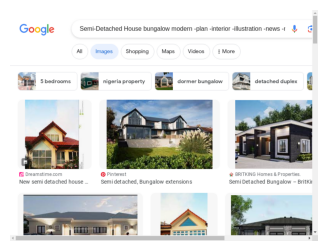

In [13]:
# @title check driver state
# from PIL import Image
# import matplotlib.pyplot as plt
driver.get_screenshot_as_file("canvas.png")
image = Image.open('canvas.png').convert("RGB")
plt.figure(figsize=(5, 3))
plt.axis('off')
plt.imshow(image)
plt.show()

# print(driver.page_source)


In [ ]:
# @title click images
# click in each image, way too slow
# driver.get(url)


# img_urls=[]
# try: WebDriverWait(driver, 2).until(EC.presence_of_element_located((By.XPATH, "*//a[@class='wXeWr islib nfEiy']")))
# except: pass
hits = driver.find_elements(By.XPATH,"*//a[@class='wXeWr islib nfEiy']") # images
print(len(hits))
# hits[0].click()
import time
start = time.time()
# driver.execute_script("arguments[0].click();"
for i, button in enumerate(hits):
    hits[i].click()
    end = time.time()
    print(end-start)
    start=end
    # get img url from clicking
#     try: img_src = driver.find_elements(By.XPATH,"*//img[@jsname='kn3ccd']")[0].get_attribute("src")
#     except: continue
#     # img_src = driver.find_elements(By.XPATH,"*//a[@class='Du2c7e']")[0].get_attribute("href")
#     # img_src = driver.find_elements(By.XPATH,"*//a[@class='Du2c7e']/img")[0].get_attribute("src")
#     print(i, img_src)
#     img_urls.append(img_src)
    # if i>3: break
# print(len(img_urls))


driver.execute_script("hits = document.getElementsByClassName('wXeWr islib nfEiy')")

print(len(hits))

import time
start = time.time()
for i, x in enumerate(hits):
# for i in range(5):
    end = time.time()
    driver.execute_script("hits["+str(i)+"].click();")
    print(i, end-start)
    start=end
# 8m50s



In [ ]:
# @title urls from page_source
# driver.get(url)

pro=driver.page_source
# pro=driver.execute_script("return document.documentElement.outerHTML")

from urllib.parse import unquote
pro = unquote(pro)
# print(pro[2000000:])
pro = pro.encode().decode('unicode-escape') # try to remove \\u00
# print(pro)
print(len(pro)) # , 2617498, 2977434, 3468337
# 1389443

import re
# pattern = r"https://(?:(?!\").)*\.jpg" # start with https:// , no " , end with .jpg # https://stackoverflow.com/a/67540659/13359815
pattern = r"(?<=href=\"/imgres\?imgurl=)(?:(?!&amp;).)*(?=&amp;)" # start with href="/imgres?imgurl= , no &amp; , end with &amp; # https://stackoverflow.com/a/3926546/13359815
# pattern = r"https://(?:(?!\").)*(?=\")" # start with https:// , no " , end with " # all urls
# pattern = r"(?<=\],\[\")https://(?:(?!\").)*(?=\")" # start with ],[" then https:// , no " , end with " # all imgs? fast

# print(pro.count("imgurl"))

m = re.findall(pattern, pro)
# print(m)
print(len(m)) # 73

# for i, x in enumerate(m):
#     print(i, x)


3482470
787


<ipython-input-29-a0c00dd5fe75>:9: DeprecationWarning: invalid escape sequence '\s'
  pro = pro.encode().decode('unicode-escape') # try to remove \\u00


In [ ]:
# @title check url
import requests
for i, x in enumerate(m):
    # print(x)
    response = requests.get(x)
    print(i, response.status_code == 200)
    # print(response=200)
    # print(response.json())
    # if response.json()['status'] != 'OK': return
    # lat, lng = response.json()['location'].values()
    # if i>3: break

# response = requests.get(x)
# # print(response.json())
# print(response)


# print(m)
# print(len(m))
# !pip install Pillow --upgrade
from PIL import Image
import requests
import matplotlib.pyplot as plt

for i in range(2,5):
    # print(m[i])
    response = requests.get(m[i], stream=True)
    # print(response)
    # print(response.raw)
    img = Image.open(response.raw)
    # try: img = Image.open(response.raw)
    # except: continue
    plt.imshow(img)
    plt.show()


## wwwwwwwww

In [ ]:
# @title setup pandas
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df_explore = pd.read_excel("/content/drive/MyDrive/explore_url.xlsx", engine='openpyxl') # urls to explore
df_home = pd.read_excel("/content/drive/MyDrive/home_urls.xlsx", engine='openpyxl') # good img urls
# display(df)
# img_seemor = [] # temp img url and seemor urls

# df_all = df_all[~df_all['api date'].isnull() &(df_all['bad']!=1)]
# df_all = df_all[df_all['Latitude']=='None']
# df_all = df_all[(df_all['bad']==1) & (df_all['blur']!=1)] # 3061
# print(len(df_all))
# print(len(df_all[df_all['Latitude']=='None']))
# Property Address Cleaned

# print(len(df_all[df_all['name'].isnull()]))
# df_all = df_all[df_all['name'].isnull()]


In [ ]:
# import os
# os.mkdir("/content/ggmap_frombad")
# for x in range(1,7):
#     os.mkdir("/content/ggmap_frombad/0"+str(x))


In [ ]:
# @title setup / model
# https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

import numpy as np
import torch
# from pkg_resources import packaging
# print("Torch version:", torch.__version__)
import clip
# clip.available_models()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, preprocess = clip.load("ViT-B/32") # preprocess: normalize intensity using dataset mean and sd then resize and center-crop to conform to the model expects.
# model.cuda().eval()
model.to(device).eval()
input_resolution = model.visual.input_resolution # 224
context_length = model.context_length # 77
vocab_size = model.vocab_size # 49408
# print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}") # 151,277,313
# clip.tokenize("Hello World!") # case-insensitive tokenizer, padded to become 77 tokens


In [ ]:
# @title house main




# for img_file, blurrness in zip(img_file_list, blurrness_list):
# for x,filename in enumerate(left):
# for x,(location, filename) in enumerate(zip(location_list, filename_list)):
for x,(location, filename) in enumerate(zip(location_list[start:], filename_list[start:])):
# for x,(olat, olng, filename) in enumerate(zip(latitude_list[start:], longitude_list[start:], filename_list[start:])):
    # if x in [34,40,62]:
    #     continue
    print(x)

    try:
        i = df_all.index[df_all['Filename'] == filename][0]
    except: i = df_all.index[df_all['Filename'] == filename.replace('-','/').replace('_','/')][0]
    # print(i)
    # df_all.at[i, 'glat'] = olat
    # df_all.at[i, 'glng'] = olng
    df_all.at[i, 'gdate'] = date
    df_all.at[i, 'name'] = filename
    # print(loc)

    cls=filename.split('. ')[0]
    filename=filename.replace("/", "-")

    pic_dir = file_dir+'/'+cls+'/'+filename + ' ' + date + '.jpg'

    with open(pic_dir, 'wb') as pic_file:
        pic_file.write(pic_content)
    # image = Image.open(pic_dir).convert("RGB")
    # plt.figure(figsize=(5, 4))
    # plt.axis('off')
    # plt.imshow(image)
    # plt.show()

    # t+=1
    # if t >=5: break

df_all.to_excel('/content/drive/MyDrive/properties_batch.xlsx', index=False, header=False)

# No Street View imagery available here


In [ ]:
import os
# allfiles = os.listdir('/content/gmap/01/')
# print(len(allfiles))

count=0
for x in range(1,7):
    allfiles = os.listdir('/content/ggmap_frombadt/0'+str(x)+'/')
    count+=len(allfiles)
print(count)


2918


In [ ]:
print(list(df_all['Filename']))

In [ ]:
# @title zfill date

t=0
for x in range(1,7):
    img_dir = '/content/gmap_clean_/0'+str(x)
    for filename in os.listdir(img_dir):
        # print(filename)
        name = os.path.splitext(filename)[0]

        # print(name)
        date=name.split(' ')[-1]
        # print(date)
        yyyy,m=date.split('-')
        date=yyyy+'-'+m.zfill(2)
        filename1 = ' '.join(name.split(' ')[:-1])+' '+date+'.jpg'
        img_file=os.path.join(img_dir, filename)
        img_file1=os.path.join(img_dir, filename1)
        # print(img_file)
        # print(img_file1)
        os.rename(img_file, img_file1)
        # t+=1
        # if t>44: break


In [ ]:
# @title check date / sheet img file
import os
from PIL import Image
import matplotlib.pyplot as plt

img_dir = '/content/ggmap_frombad/06'

t=0
for filename in os.listdir(img_dir):
    # print(filename)
    name = os.path.splitext(filename)[0]
    img_file=os.path.join(img_dir, filename)

    # print(name)
    date=name.split(' ')[-1]
    # print(date)
    find_name = name[:-8]
    # print(find_name)

    try:
        i = df_all.index[df_all['Filename'] == find_name][0]
        # print(i)
    except:
        # print("nope")
        i = df_all.index[df_all['Filename'] == find_name.replace('-','/').replace('_','/')][0]
    # print(i)
    df_all.at[i, 'old'] = date
    # df_all.at[i, 'img file'] = filename
    df_all.at[i, 'name'] = find_name
    # t+=1
    # if t >=5: break

df_all.to_excel('/content/drive/MyDrive/properties_batch.xlsx', index=False, header=False)




In [ ]:
# display(df_all.head())
df_all

## from clean

In [ ]:
# @title data
from torchvision import datasets#, transforms

# dir='/content/google_street_view'
dir='/content/gsv70k'

# # data = datasets.ImageFolder(dir, transform=transform)
data = datasets.ImageFolder(dir, transform=None)
torch.manual_seed(0)


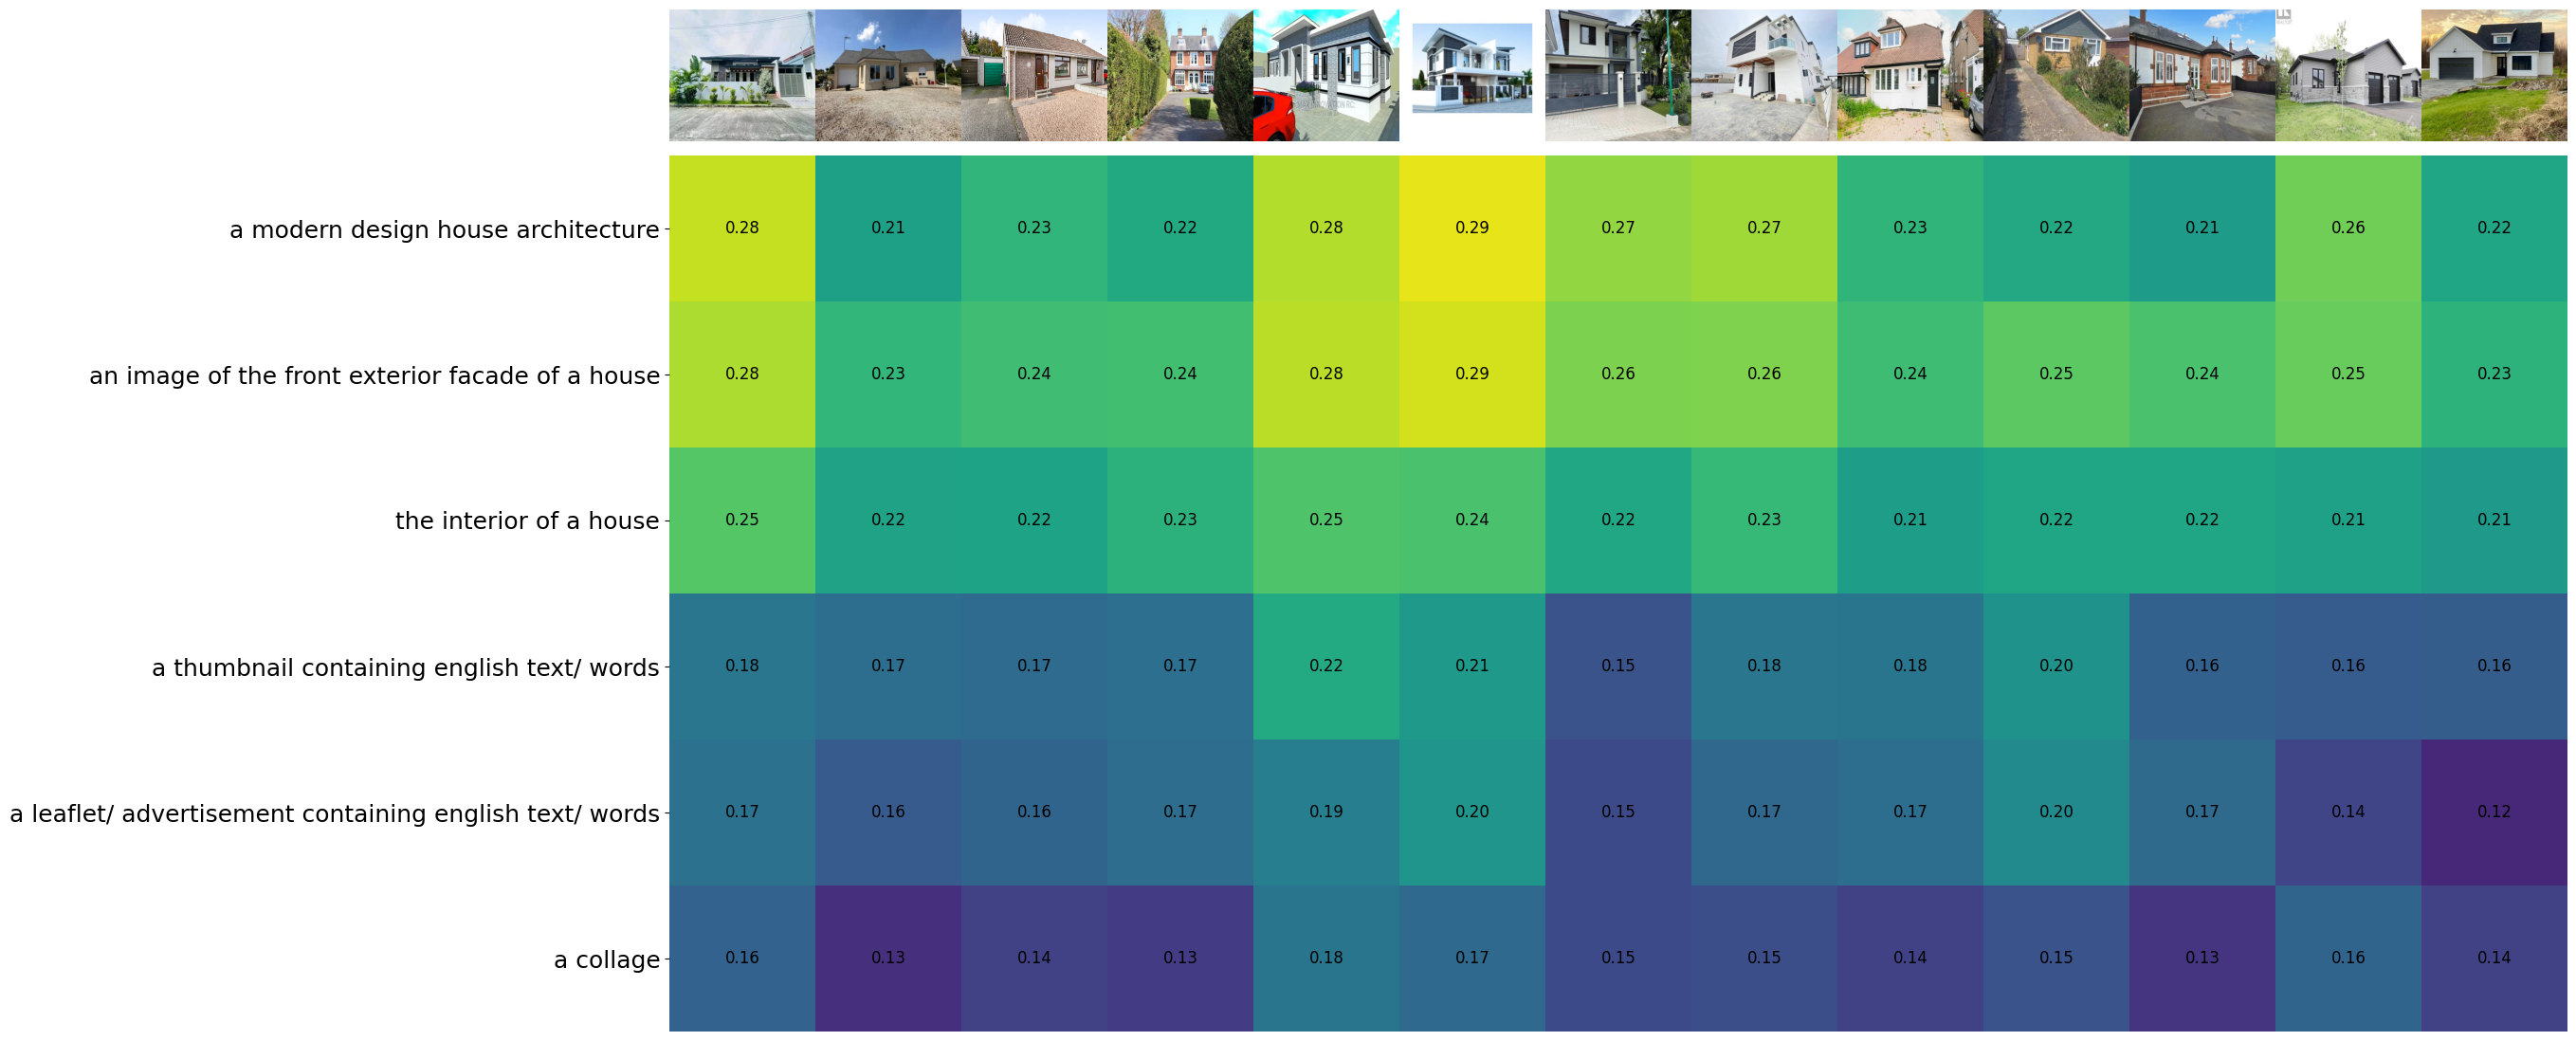

In [ ]:
# @title test texts
images=[]
og_img=[]

# [76,]

c=90
for i in range(c,c+15):
    # response = requests.get(m[i], stream=True)
    try: response = requests.get(m[i], stream=True)
    except: continue
    # img = Image.open(response.raw)
    try: img = Image.open(response.raw)
    except: continue
    images.append(preprocess(img))
    og_img.append(img)

# texts=['an image of the exterior facade of a modern house','an image of the exterior facade of a house','the interior of a house','an image with text words','a collage']
texts=['a modern design house architecture','an image of the front exterior facade of a house','the interior of a house','a thumbnail containing english text/ words','a leaflet/ advertisement containing english text/ words','a collage']

# housing facade, house front

# interior of a
# facade of a modern house
# text/ words


# normalize images, tokenize text input, forward pass model to get image text features
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)
# text_tokens = clip.tokenize(texts).to(device)

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# Calculating cosine similarity: normalize features and calculate dot product of each pair.
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
# print(similarity)

count = len(texts)

import matplotlib.pyplot as plt
# plt.figure(figsize=(20, 14))
plt.figure(figsize=(30, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(og_img):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, len(og_img) - 0.5])
# plt.ylim([count + 0.5, -2])
plt.ylim([count - 0.5, -1.5]) # bottom, top margin
plt.show()
# plt.title("Cosine similarity between text and image features", size=20)


In [ ]:
# @title base get similarity

images=[]
og_img=[]

c=110
for i in range(c,c+10):
    img,label=data[i]
    images.append(preprocess(img))
    og_img.append(img)

texts=['a modern design house architecture','an image of the front exterior facade of a house','the interior of a house','a thumbnail containing english text/ words','a leaflet/ advertisement containing english text/ words','a collage']


# normalize images, tokenize text input, forward pass model to get image text features
image_input = torch.tensor(np.stack(images)).to(device)
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)


with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

# Calculating cosine similarity: normalize features and calculate dot product of each pair.
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
# similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

similarity = text_features @ image_features.T
print(similarity)

# blur 0.23



In [48]:
# @title collect
# use clip to get similarity scores for all images
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

texts=['a modern design house architecture','an image of the front exterior facade of a house','the interior of a house','a thumbnail containing english text/ words','a leaflet/ advertisement containing english text/ words','a collage']

text_tokens = clip.tokenize(["This is " + desc for desc in texts]).to(device)
with torch.no_grad(): text_features = model.encode_text(text_tokens).float()
text_features /= text_features.norm(dim=-1, keepdim=True)



def get_img(uuu):
    # print(uuu)
    try:
        response = requests.get(uuu, stream=True)
        image = Image.open(response.raw)
        image = preprocess(image)
        # return image
        return uuu, image
    except: return


batch_size = 1024 # 16

from concurrent.futures import ThreadPoolExecutor



sall=torch.empty(0, device=device)
# for i, uuu in enumerate(m[:5]):
# for i, uuu in enumerate(m):
for i in range(0, len(m), batch_size):
    # i=0
    print(i)
    start = time.time()
    # e = ThreadPoolExecutor(batch_size) # 19.788sec
    e = ThreadPoolExecutor(min(batch_size, len(m))) # 21sec

    # result = e.map(get_img, m[i*batch_size: min((i+1)*batch_size, len(m))])
    # # result = e.map(get_img, m)
    # result = list(filter(lambda item: item is not None, result))

    future = [e.submit(get_img, uuu) for uuu in m[i*batch_size: min((i+1)*batch_size, len(m))]]
    # result = [f.result() for f in future if f.result() is not None]
    ulst = [f.result()[0] for f in future if f.result() is not None]
    images = [f.result()[1] for f in future if f.result() is not None]
    # imgidx = [i for i in range(len(future)) if future[i].result() is not None]

    end = time.time()
    print(end-start)
    start=end

    images = torch.tensor(np.stack(images)).to(device)
    print(images.shape)
    # img= preprocess(images).to(device).unsqueeze(0)
    with torch.no_grad():
        image_features = model.encode_image(images).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = text_features @ image_features.T
    # print(similarity.squeeze())
    sall = torch.cat((sall, similarity.squeeze().T))

print(sall)
# 19.6s


0
19.60586977005005
torch.Size([677, 3, 224, 224])
tensor([[0.2744, 0.3159, 0.2695, 0.2161, 0.1967, 0.1834],
        [0.2772, 0.2674, 0.2511, 0.1869, 0.1779, 0.1551],
        [0.2501, 0.2883, 0.2357, 0.2033, 0.2014, 0.1663],
        ...,
        [0.2392, 0.2760, 0.2502, 0.2041, 0.1764, 0.1485],
        [0.2263, 0.2412, 0.2226, 0.1882, 0.1937, 0.1371],
        [0.2142, 0.2351, 0.2230, 0.1961, 0.1796, 0.1461]], device='cuda:0')


In [55]:
# imgidx = [i for i in range(len(future)) if future[i].result() is not None]
# print(imgidx)
# print(len(ulst),len(imgidx))
print(ulst)
print(len(ulst))

def ind_img(idx):
    try:
        response = requests.get(ulst[idx], stream=True)
        image = Image.open(response.raw)
        # image = preprocess(image)
        return image
    except:
        print(idx)
        print(ulst[idx])
        return

indlst = list(range(len(ulst)))
from concurrent.futures import ThreadPoolExecutor
e = ThreadPoolExecutor(len(indlst))
result = list(e.map(ind_img, indlst))


['https://thumbs.dreamstime.com/z/new-semi-detached-house-5562412.jpg', 'https://i.pinimg.com/originals/7d/17/25/7d17259e247561eea5d80cdc27bf9dec.jpg', 'https://thumbs.dreamstime.com/b/new-semi-detached-house-5562395.jpg', 'https://1.bp.blogspot.com/-AxWV_asGEZ4/Xcu0Q6dsMeI/AAAAAAAABbY/H5YsogL6Jx8dVZUI6NpZgToPkaHiBbQ7QCEwYBhgL/s1600/Solomon%2BAliu%2BHouse_Ara.jpg', 'https://britkingproperties.com/wp-content/uploads/2023/03/WhatsApp-Image-2023-02-21-at-8.34.28-AM-1-525x328.jpeg', 'https://images.nigeriapropertycentre.com/properties/images/1425538/062fd22c361052-2bedroom-semi-detached-bungalow-semi-detached-bungalows-for-sale-idu-industrial-abuja.jpg', 'https://i.pinimg.com/originals/e7/58/13/e758137dd5b63b4ac800b3bde95744e2.jpg', 'https://res.klook.com/klook-hotel/image/upload/fl_lossy.progressive,c_fill,w_750,q_85/travelapi/81000000/80730000/80722300/80722217/5dca2b24_z.webp', 'https://cdn2-property.estateapps.co.uk/files/property/52/image/HENDERSONSETTER_HENDE003380/HENDERSONSETTER_HE

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=584x361 at 0x7F98B001E680>


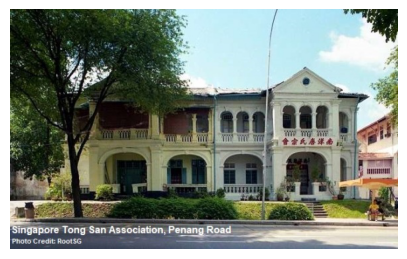

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
# from torchvision import transforms

tu = "https://remembersingapore.files.wordpress.com/2020/04/singapore-tong-san-association-penang-road-1980s.jpg?w=584"
# tu = "https://realtysolutionsremax.files.wordpress.com/2019/04/20190220_170150_resized.jpg?w=584"
# tu = "https://propertyzaikia.files.wordpress.com/2020/11/20200807_123819-1.jpg?w=1024"

response = requests.get(tu, stream=True)
image = Image.open(response.raw)
print(image)
plt.figure(figsize=(5, 4))
plt.axis('off')
plt.imshow(image)
plt.show()


In [33]:
print(result)


<generator object Executor.map.<locals>.result_iterator at 0x7fea506ab610>


In [ ]:
# @title
import torchvision
from torchvision import transforms

great, good, interior, word, collage, left = [],[],[],[],[],[]
great_s, good_s, interior_s, word_s, collage_s, left_s = [],[],[],[],[],[]

texts=['a modern design house architecture','an image of the front exterior facade of a house','the interior of a house','a thumbnail containing english text/ words','a leaflet/ advertisement containing english text/ words','a collage']

length = len(sall[0])

t=0
# for i, similarity in sall:
# for i, similarity in enumerate(sall):
for idx, similarity in enumerate(sall):
    # idx = imgidx[i]
    modern = similarity[0]
    house = similarity[1]
    inter = similarity[2]
    text = similarity[3]
    ad = similarity[4]
    colge = similarity[5]

    # print(i, similarity)
    # great, good, interior, word, collage, left

    if inter>=0.27:
        interior.append(idx)
        interior_s.append(similarity)
    elif text>=0.20 or ad>=0.20:
        word.append(idx)
        word_s.append(similarity)
    # elif colge>=0.22:
    #     collage.append(idx)
    #     collage_s.append(similarity)

    # elif house<0.23 or (length-2)*house-similarity[2:].sum()<0.01 or house-iter<0.01 or house-text<0.01 or house-ad<0.01 or house-colge<0.01:
    elif house<0.23 or (length-2)*house-similarity[2:].sum()<0.01:# or house-iter<0.01 or house-text<0.01 or house-ad<0.01 or house-colge<0.01:
        left.append(idx)
        # print((length-2)*house-similarity[2:].sum())
        left_s.append((length-2)*house-similarity[2:].sum())
        # left_s.append(similarity)
    elif modern>=0.27: # great
        great.append(idx)
        great_s.append(similarity)
    else: # good
        good.append(idx)
        good_s.append(similarity)
    # print(similarity[1:].sum()-similarity[0])
    # t+=1
    # if t >=5: break


# great, good, interior, word, collage, left

print("sall",len(sall))
print("great",len(great))
print("good",len(good))
print("interior",len(interior))
print("word",len(word))
print("collage",len(collage))
print("left",len(left))



In [ ]:
# @title display imgs

import matplotlib.pyplot as plt

plt.axis('off')


def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    # plt.figure(figsize = (20,15))
    plt.figure(figsize=(30, 14))
    # plt.figure(figsize = (16,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def ind_img(ind):
    try:
        response = requests.get(ulst[ind], stream=True)
        image = Image.open(response.raw)
        image = preprocess(image)
        return image
    except: return


from concurrent.futures import ThreadPoolExecutor
def ind2img(indlst):
    e = ThreadPoolExecutor(len(indlst))
    result = e.map(ind_img, indlst)
    # future = [e.submit(ind_img, ind) for ind in indlst]
    # result = [f.result() for f in future if f.result()]


c=0
start = time.time()

print(ind2img(great[c:c+64]))

imshow(torchvision.utils.make_grid(ind2img(great[c:c+64])))
end = time.time()
print(end-start)
start=end




In [ ]:
def file2img(img_files):
    imgs=[]
    for img_file in img_files:
        image = Image.open(img_file).convert("RGB")
        image=transforms.ToTensor()(image)
        imgs.append(image)
    return imgs


# imshow(torchvision.utils.make_grid(file2img(good[c:c+64])))

imshow(torchvision.utils.make_grid(great[c:c+64]))
# imshow(torchvision.utils.make_grid(file2img(great[c:c+64])))
# imshow(torchvision.utils.make_grid(file2img(good[c:c+64])))
# imshow(torchvision.utils.make_grid(file2img(interior)))
# imshow(torchvision.utils.make_grid(file2img(word[c:c+64])))
# # imshow(torchvision.utils.make_grid(file2img(left[c:c+100]),nrow=10))
# imshow(torchvision.utils.make_grid(file2img(left[c:c+64])))


print(obscured[c:c+64])


['/content/gsv70k/01/01. 20 BUTTERFLY AVE 2022-03.jpg', '/content/gsv70k/01/01. 9 JLN LABU AYER 2019-05.jpg', '/content/gsv70k/01/01. 7 LUCKY CRES 2022-09.jpg', '/content/gsv70k/01/01. 1A GUILLEMARD RD 2022-04.jpg', '/content/gsv70k/01/01. 102 JLN KURAS 2019-08.jpg', '/content/gsv70k/01/01. 38 PEACH GDN 2022-10.jpg', '/content/gsv70k/01/01. 30 JLN ASAS 2022-11.jpg', '/content/gsv70k/01/01. 17 ELITE TER 2022-09.jpg', '/content/gsv70k/01/01. 8 HAIG AVE 2022-05.jpg', '/content/gsv70k/01/01. 22 LIMAU GDN 2022-09.jpg', '/content/gsv70k/01/01. 92A GUILLEMARD RD 2022-09.jpg', '/content/gsv70k/01/01. 94 BRANKSOME RD 2022-03.jpg', '/content/gsv70k/01/01. 4 FIDELIO ST 2023-01.jpg', '/content/gsv70k/01/01. 132 MARSHALL RD 2022-10.jpg', '/content/gsv70k/01/01. 54 LICHI AVE 2018-03.jpg', '/content/gsv70k/01/01. 17 NAROOMA RD 2022-09.jpg', '/content/gsv70k/01/01. 22A BRIGHTON AVE 2019-04.jpg', '/content/gsv70k/01/01. 24 ROBERTS LN 2022-10.jpg', '/content/gsv70k/01/01. 442 MACPHERSON RD 2022-03.jpg',

In [ ]:
for i,x in enumerate(left_s):
    print(i, x.item())

In [ ]:
# @title count imgs
# count num of imgs in each class
tt=0
for x in range(1,7):
    allfiles = os.listdir('/content/gsv70kg/0'+str(x))
    # allfiles = os.listdir('/content/gmap_clean/0'+str(x))
    # allfiles = os.listdir('/content/ggmap/0'+str(x))
    # allfiles = os.listdir('/content/ggmap_frombad/0'+str(x))
    print(x, len(allfiles))
    tt+=len(allfiles)
print("tt",tt)

1 14717
2 8540
3 19817
4 14812
5 9559
6 493
tt 67938


In [ ]:
# @title make new folders
import os
for x in range(1,7):
    fol = '/content/ggmap/0'+str(x)
    if not os.path.exists(fol):
        os.makedirs(fol)

In [ ]:
# @title move files
import os
import shutil

# allfiles = os.listdir(source)
# for f in allfiles:
#     src_path = os.path.join(source, f)
#     dst_path = os.path.join(destination, f)
#     shutil.copyfile(src_path, dst_path)


c=0
source = '/content/gmap_clean/'
destination = '/content/gsv70k_clip/'
for x in range(1,7):
    allfiles = os.listdir(source+'0'+str(x))
    # # for src_path in good:
    for f in allfiles:
        # f=src_path.split('/')[-1]

        src_path = source+f[:2]+'/' +f
        dst_path = destination+f[:2]+'/' +f
        # print(src_path, dst_path)
        shutil.copyfile(src_path, dst_path)
        # c+=1
        # if c>5: break




In [ ]:
# @title resize imgs
# gmap: 1024,648 ; api: 640, 400
from PIL import Image
import os

c=0
for x in range(1,7):
    fol = '/content/gmap/0'+str(x)
    gfol = '/content/ggmap/0'+str(x)
    files=os.listdir(fol)
    for file in files:
        # print(file)
        im = Image.open(fol+'/'+file)
        width, height = im.size
        # print(width, height)
        im = im.resize((640, 400))
        im = im.convert('RGB')
        im.save(gfol+'/'+file)
        # print(fol+'/'+file)
        # print(gfol+'/'+file)
        # c+=1
        # if c>5: break


##save

In [ ]:
!ls -a /content/ggmap_frombad
# !rm -R /content/gsv/.ipynb_checkpoints
# %cd /content
!ls

# sometimes random .ipynb_checkpoints files gets placed in the folders, delete them before zipping
!rm -R /content/ggmap_frombad/.ipynb_checkpoints
!rm -R /content/ggmap_frombad/01/.ipynb_checkpoints
!rm -R /content/ggmap_frombad/02/.ipynb_checkpoints
!rm -R /content/ggmap_frombad/03/.ipynb_checkpoints
!rm -R /content/ggmap_frombad/04/.ipynb_checkpoints
!rm -R /content/ggmap_frombad/05/.ipynb_checkpoints
!rm -R /content/ggmap_frombad/06/.ipynb_checkpoints

!zip -r /content/drive/MyDrive/ggmap_frombad3.zip /content/ggmap_frombad


In [ ]:
!unzip /content/drive/MyDrive/ggmap_frombad3.zip -d /


In [ ]:
# !rm -R /content/ggmap_frombad

# @title move files
import os
import shutil

# allfiles = os.listdir(source)
# for f in allfiles:
#     src_path = os.path.join(source, f)
#     dst_path = os.path.join(destination, f)
#     shutil.copyfile(src_path, dst_path)

source = '/content/ggmap_frombad/06/06/'
destination = '/content/ggmap_frombad/06'
c=0

for filename in os.listdir(source):
# for src_path in good:
    src_path = os.path.join(source, filename)
    # f=src_path.split('/')[-1]
    # print('/'.split(name))
    # print(destination, f)
    dst_path = os.path.join(destination, filename)
    # print(filename)
    # print(src_path)
    # print(dst_path)
    # shutil.copyfile(src_path, dst_path)
    shutil.move(src_path, dst_path)
    # print(src_path, dst_path)
    # c+=1
    # if c>5: break





In [ ]:
#@title Quit driver
driver.quit()
display.stop_display()